In [1]:
import diffusers
import transformers
import sys
import shutil
import time
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
import torch
import os
import random
import requests
from io import BytesIO
import numpy as np
import subprocess
from torchvision import models, transforms
import dlib
from PIL import Image, ImageFilter, ImageDraw, ImageEnhance
import cv2
from pathlib import Path
import math
import matplotlib.pyplot as plt

from scipy.ndimage import binary_closing

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def get_background_pixels_and_bbox(pil_img, blur_radius=0, bbox_padding=0, mask_parts=None):
    from PIL import Image, ImageFilter, ImageOps
    import numpy as np
    import mediapipe as mp
    if mask_parts is None:
        mask_parts = ["clothing"]
    elif isinstance(mask_parts, str):
        mask_parts = [mask_parts]

    mask_dict = {
        "background": 0,
        "hair": 1,
        "skin": 2,
        "face": 3,
        "clothing": 4,
        "others": 5
    }

    # Blur the image background based on the segmentation mask.
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=np.asarray(pil_img))
    options = mp.tasks.vision.ImageSegmenterOptions(
        base_options=mp.tasks.BaseOptions(model_asset_path="src/models/selfie_multiclass_256x256.tflite"),
        running_mode=mp.tasks.vision.RunningMode.IMAGE,
        output_category_mask=True)
    
    with mp.tasks.vision.ImageSegmenter.create_from_options(options) as segmenter:
        segmentation_result = segmenter.segment(image)
        combined_mask = np.zeros_like(segmentation_result.confidence_masks[0].numpy_view())

        for mask_part in mask_parts:
            if mask_part in mask_dict:
                body_mask = segmentation_result.confidence_masks[mask_dict[mask_part]].numpy_view()
                binary_mask = body_mask > 0.25
                combined_mask = np.logical_or(combined_mask, binary_mask)

        condition = np.stack((combined_mask,) * 3, axis=-1)
        mask = np.where(condition, 255, 0).astype(np.uint8)
        mask = Image.fromarray(mask)
        blurred_mask = mask.filter(ImageFilter.GaussianBlur(blur_radius)).convert("RGB")

        # Calculate bounding box (bbox) from the blurred_mask pixels
        mask_array = np.array(blurred_mask)[:,:,0] # Convert mask to a NumPy array and take one channel
        
        # Ensure that we are only considering non-zero values for our bbox calculation
        non_zero_indices = np.where(mask_array > 0) # Indices of non-zero elements
        if non_zero_indices[0].size > 0 and non_zero_indices[1].size > 0:
            y_min, y_max = non_zero_indices[0].min(), non_zero_indices[0].max()
            x_min, x_max = non_zero_indices[1].min(), non_zero_indices[1].max()
            
            width = x_max - x_min
            height = y_max - y_min
            
            # Determine the size of the square bbox
            bbox_size = max(width, height)
            
            # Calculate the amount of padding needed on each side
            x_padding = (bbox_size - width) // 2
            y_padding = (bbox_size - height) // 2
            
            # Update the bbox coordinates to make it a square
            x_min = max(0, x_min - x_padding)
            y_min = max(0, y_min - y_padding)
            x_max = min(mask_array.shape[1] - 1, x_max + x_padding + (bbox_size - width) % 2)
            y_max = min(mask_array.shape[0] - 1, y_max + y_padding + (bbox_size - height) % 2)
            
            
            bbox = (x_min, y_min, x_max, y_max)
        else:
            bbox = None
    
        facemask = blurred_mask.crop(bbox)
        return facemask, bbox

I0000 00:00:1713145554.639420   72010 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713145554.689676   72591 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


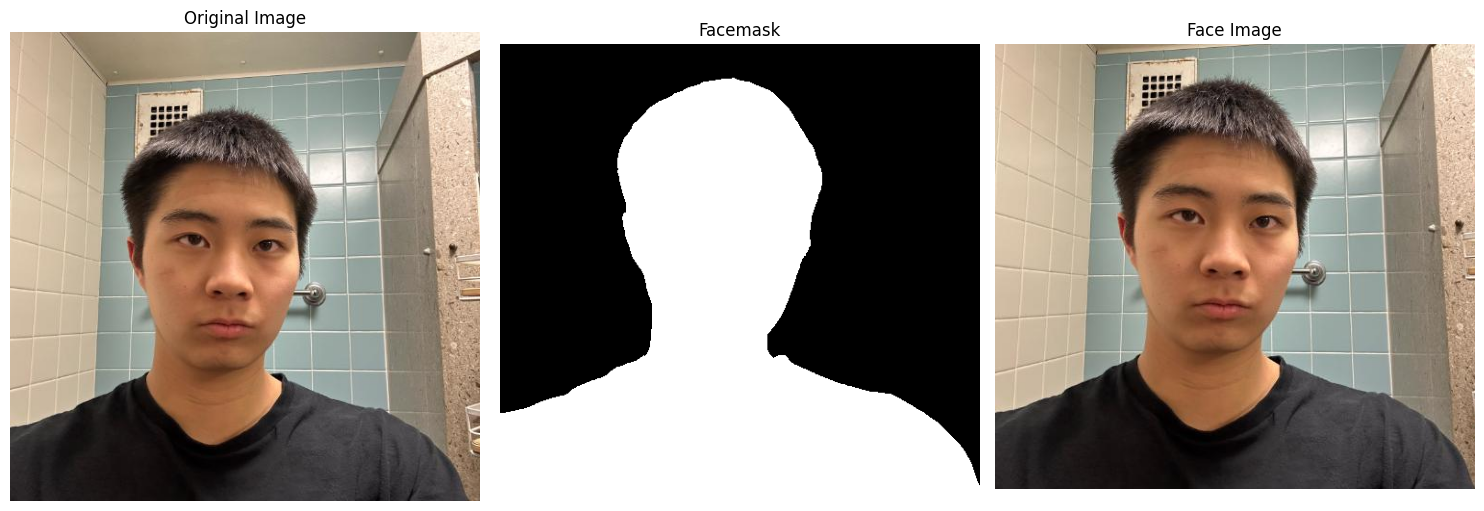

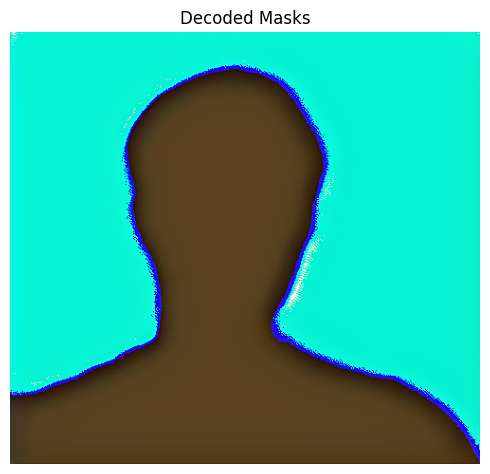

In [14]:

    
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

instance_image = Image.open("src/user_images/ohmw (11).jpg")

facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['hair', 'skin', 'face', 'clothing'], bbox_padding=0)
face_image = instance_image.crop(bbox)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(facemask)
ax2.set_title("Facemask")
ax2.axis("off")

ax3.imshow(face_image)
ax3.set_title("Face Image")
ax3.axis("off")

plt.tight_layout()
plt.show()

from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

masks = facemask.convert("RGB")
masks = np.array(masks).astype(np.float32) / 255.0
masks = masks[None, ...]  # Add batch dimension
masks = torch.from_numpy(masks).permute(0, 3, 1, 2)  # Convert to tensor and transpose dimensions

encoded_masks = vae.encode(masks).latent_dist.sample()
encoded_masks = encoded_masks * vae.config.scaling_factor

decoded_masks = vae.decode(encoded_masks).sample
decoded_masks = decoded_masks.detach().permute(0, 2, 3, 1).squeeze().cpu().numpy()  # Convert back to numpy array
decoded_masks = (decoded_masks * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_masks)
ax.set_title("Decoded Masks")
ax.axis("off")
plt.tight_layout()
plt.show()

I0000 00:00:1713131518.907922   46467 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713131518.958140   46558 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


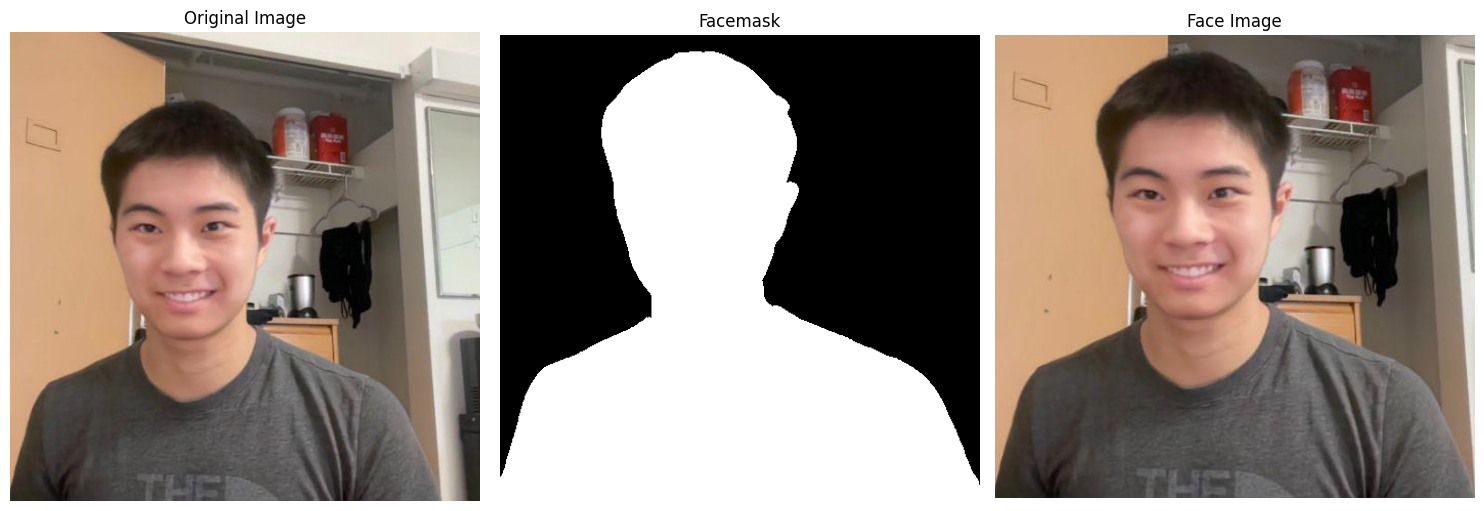

Expected input shape: torch.Size([128, 3, 3, 3])


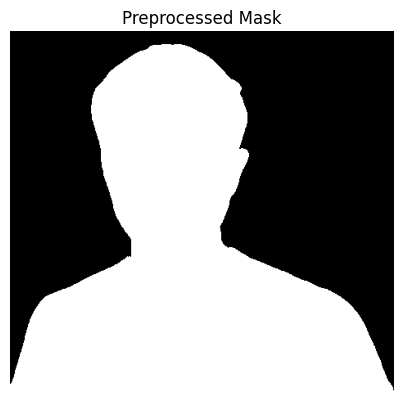

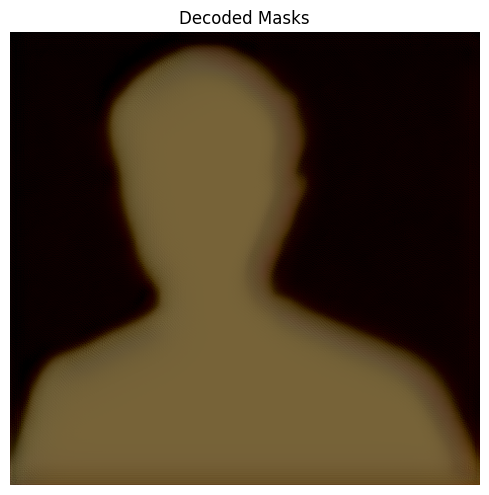

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL

instance_image = Image.open("src/user_images/ohmw (21).jpg")
facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['hair', 'skin', 'face', 'clothing'], bbox_padding=0)
face_image = instance_image.crop(bbox)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(facemask)
ax2.set_title("Facemask")
ax2.axis("off")
ax3.imshow(face_image)
ax3.set_title("Face Image")
ax3.axis("off")
plt.tight_layout()
plt.show()

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
print("Expected input shape:", vae.encoder.conv_in.weight.shape)


mask_array = np.array(facemask.convert("L")) > 0
processed_mask = mask_array.astype(np.uint8) * 255


plt.imshow(processed_mask, cmap='gray')
plt.title("Preprocessed Mask")
plt.axis("off")
plt.show()

masks = processed_mask[None, ...]
masks = np.repeat(masks, 3, axis=0)
masks = torch.from_numpy(masks).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)


encoded_masks = vae.encode(masks).latent_dist.sample()
encoded_masks = encoded_masks * vae.config.scaling_factor


decoded_masks = vae.decode(encoded_masks).sample


decoded_masks = decoded_masks.detach().squeeze().permute(1, 2, 0).cpu().numpy()
decoded_masks = np.clip(decoded_masks, 0, 1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_masks)
ax.set_title("Decoded Masks")
ax.axis("off")
plt.tight_layout()
plt.show()

I0000 00:00:1713131532.885329   46467 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713131532.936530   46609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


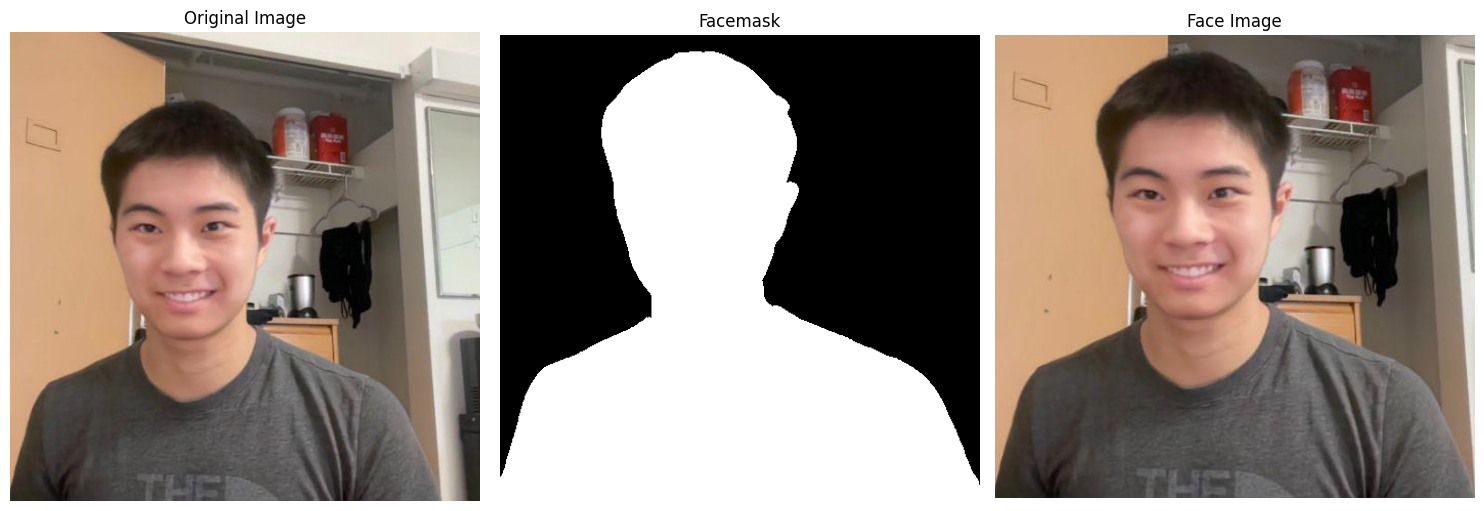

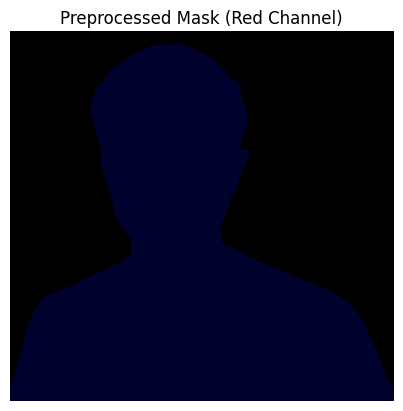

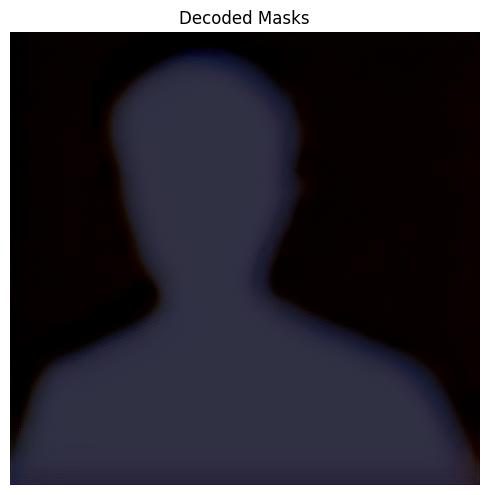

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL


instance_image = Image.open("src/user_images/ohmw (21).jpg")
facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['hair', 'skin', 'face', 'clothing'], bbox_padding=0)
face_image = instance_image.crop(bbox)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(facemask)
ax2.set_title("Facemask")
ax2.axis("off")
ax3.imshow(face_image)
ax3.set_title("Face Image")
ax3.axis("off")
plt.tight_layout()
plt.show()


vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")


mask_array = np.array(facemask.convert("L")) > 0

processed_mask = np.zeros_like(facemask.convert("RGB"))

# experimenting with different color channels
processed_mask[:, :, 0] = mask_array.astype(np.uint8) * 45
processed_mask[:, :, 1] = mask_array.astype(np.uint8) * 2
processed_mask[:, :, 2] = mask_array.astype(np.uint8) * 255


height, width = instance_image.size
processed_mask = np.transpose(processed_mask, (2, 0, 1))


plt.imshow(np.transpose(processed_mask, (1, 2, 0)))
plt.title("Preprocessed Mask (Red Channel)")
plt.axis("off")
plt.show()


masks = torch.from_numpy(processed_mask).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)


encoded_masks = vae.encode(masks).latent_dist.sample()
encoded_masks = encoded_masks * vae.config.scaling_factor


decoded_masks = vae.decode(encoded_masks).sample


decoded_masks = decoded_masks.detach().squeeze().permute(1, 2, 0).cpu().numpy()
decoded_masks = np.clip(decoded_masks, 0, 1)


fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_masks)
ax.set_title("Decoded Masks")
ax.axis("off")
plt.tight_layout()
plt.show()

I0000 00:00:1713146312.052574   72740 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713146312.101263   73271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


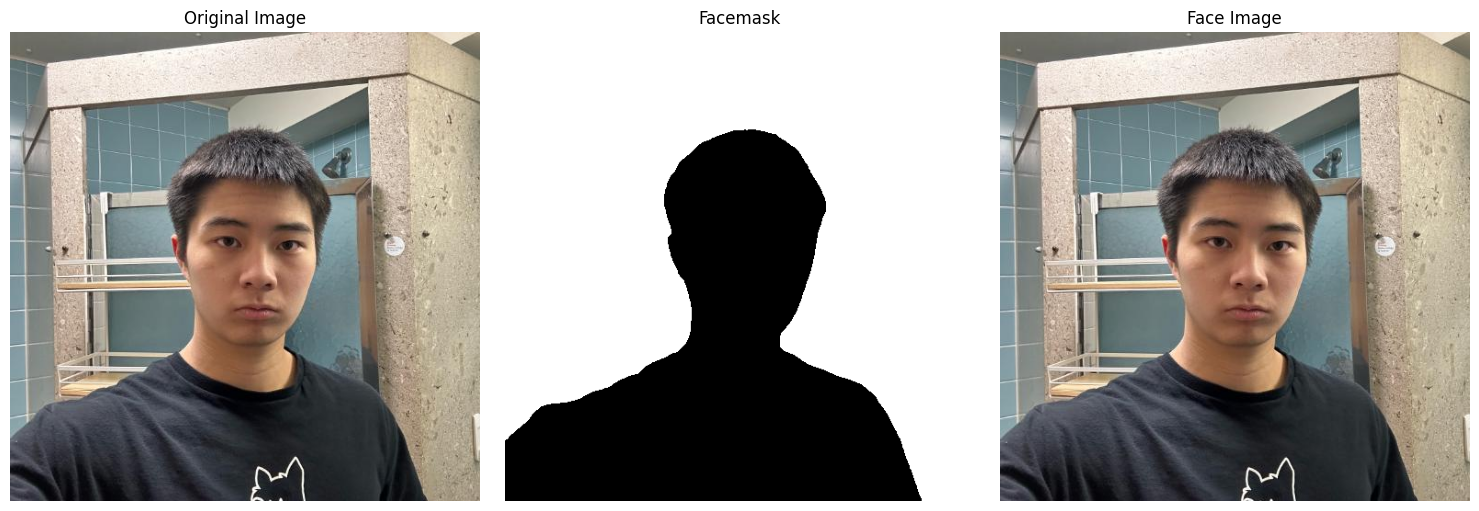

Expected input shape: torch.Size([128, 3, 3, 3])


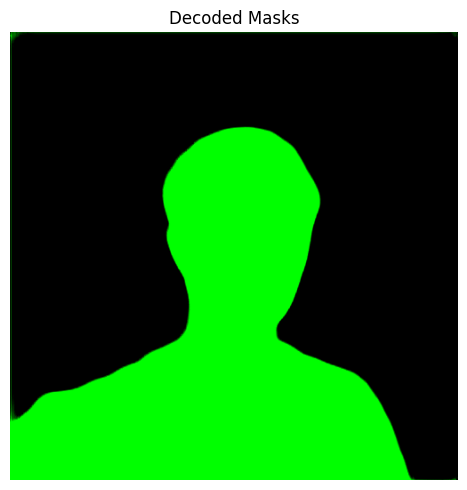

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL


instance_image = Image.open("src/user_images/ohmw (06).jpg")
# facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['hair', 'skin', 'face', 'clothing'], bbox_padding=0)

facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['background', 'others'], bbox_padding=0)

face_image = instance_image.crop(bbox)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(facemask)
ax2.set_title("Facemask")
ax2.axis("off")
ax3.imshow(face_image)
ax3.set_title("Face Image")
ax3.axis("off")
plt.tight_layout()
plt.show()


vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
print("Expected input shape:", vae.encoder.conv_in.weight.shape)


mask_array = np.array(facemask.convert("RGB")).transpose(2, 0, 1)
processed_masks = []
for channel in range(mask_array.shape[0]):
    channel_data = mask_array[channel]
    processed_mask = np.zeros_like(channel_data, dtype=np.uint8)
    processed_mask[channel_data > 0] = 255
    # processed_mask[channel_data == 0] = 0
    processed_masks.append(processed_mask)

processed_mask = np.stack(processed_masks, axis=0)
processed_mask_tensor = torch.from_numpy(processed_mask).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)



encoded_masks = vae.encode(processed_mask_tensor).latent_dist.sample()


# encoded_masks = -1 * encoded_masks
encoded_masks = 8 - encoded_masks


# encoded_masks = 10* (encoded_masks - encoded_masks.min()) / (encoded_masks.max() - encoded_masks.min())

# std_dev = encoded_masks.std()
# adaptive_scaling_factor = 1 / (std_dev + 1e-6)

# print(adaptive_scaling_factor)
# encoded_masks *= adaptive_scaling_factor

# encoded_masks = encoded_masks * vae.config.scaling_factor



decoded_masks = vae.decode(encoded_masks).sample
decoded_masks = decoded_masks.detach().squeeze().permute(1, 2, 0).cpu().numpy()
decoded_masks = np.clip(decoded_masks, 0, 1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_masks)
ax.set_title("Decoded Masks")
ax.axis("off")
plt.tight_layout()
plt.show()


I0000 00:00:1713201311.197573   14808 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713201311.267898   15283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


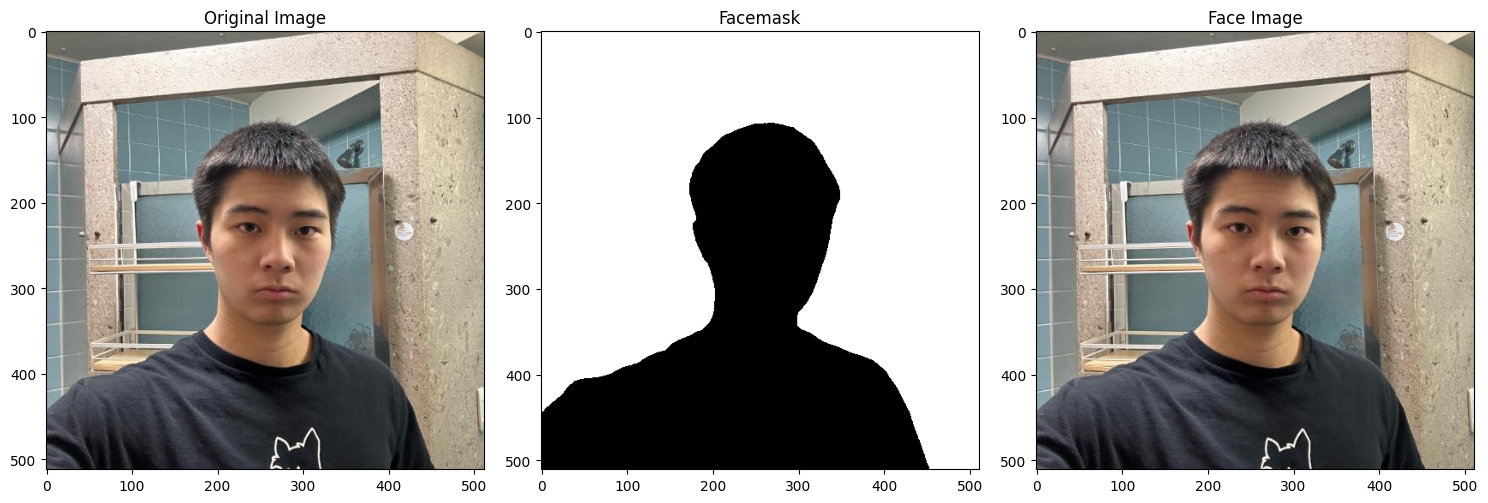

Expected input shape: torch.Size([128, 3, 3, 3])


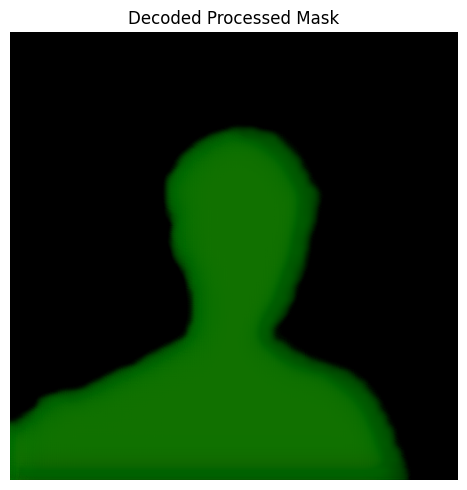

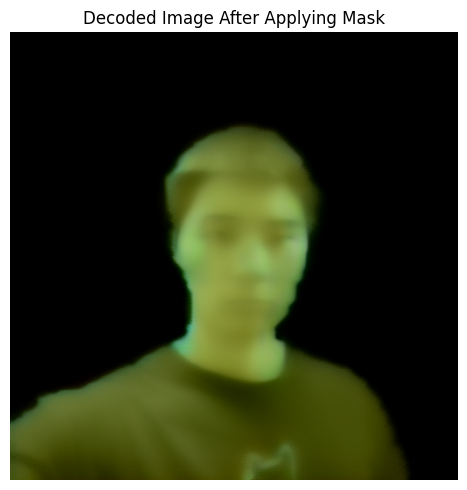

In [4]:
from PIL import Image
import numpy as np
import torch
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt


instance_image = Image.open("src/user_images/ohmw (06).jpg")
facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['background', 'others'], bbox_padding=0)
face_image = instance_image.crop(bbox)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax2.imshow(facemask)
ax2.set_title("Facemask")
ax3.imshow(face_image)
ax3.set_title("Face Image")
plt.tight_layout()
plt.show()


vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
print("Expected input shape:", vae.encoder.conv_in.weight.shape)


mask_array = np.array(facemask.convert("RGB")).transpose(2, 0, 1)
image_array = np.array(face_image.convert("RGB")).transpose(2, 0, 1)
processed_mask_tensor = torch.from_numpy(mask_array).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)
processed_image_tensor = torch.from_numpy(image_array).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)


encoded_mask = vae.encode(processed_mask_tensor).latent_dist.sample()
0
# encoded_mask = 8 - encoded_mask
# print("Inverted: ", encoded_mask)


# NORM
min_val = encoded_mask.min()
max_val = encoded_mask.max()
temp_encoded_mask = (encoded_mask - min_val) / (max_val - min_val)
# print("Normalized: ", encoded_mask)

threshold = 0.5
# multiplying by  number makes it more green too, but also gets rid of non-pure-black BG
encoded_mask = (temp_encoded_mask <= threshold).float() * 4
#print("Thresholded: ", encoded_mask)


decoded_mask = vae.decode(encoded_mask).sample
decoded_mask_image = decoded_mask.detach().cpu().squeeze().permute(1, 2, 0).numpy()
decoded_mask_image = np.clip(decoded_mask_image, 0, 1)


fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_mask_image)
ax.set_title("Decoded Processed Mask")
ax.axis("off")
plt.tight_layout()
plt.show()

# Encode and process the image
encoded_image = vae.encode(processed_image_tensor).latent_dist.sample()

multiplied_latents = (encoded_mask * encoded_image)


min_val_img = encoded_image.min()
max_val_img = encoded_image.max()
normalized_encoded_image = (encoded_image - min_val_img) / (max_val_img - min_val_img)
#print(normalized_encoded_image)


multiplied_latents = (encoded_mask * normalized_encoded_image)
# print(multiplied_latents)

# this makes the mask more "clear"
# if you remove it or just multiply by itself once, it gets more blurry
multiplied_latents = multiplied_latents * multiplied_latents # * multiplied_latents

# # Don't threshold
# threshold_value = 0.7
# multiplied_latents = (multiplied_latents > threshold_value).float() * multiplied_latents
# multiplied_latents[multiplied_latents <= threshold_value] = 0.0
# print(multiplied_latents)


decoded_result = vae.decode(multiplied_latents).sample
decoded_image = decoded_result.detach().cpu().squeeze().permute(1, 2, 0).numpy()
decoded_image = np.clip(decoded_image, 0, 1)


fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_image)
ax.set_title("Decoded Image After Applying Mask")
ax.axis("off")
plt.tight_layout()
plt.show()

I0000 00:00:1713201347.216755   14808 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713201347.292329   15541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA A10G/PCIe/SSE2


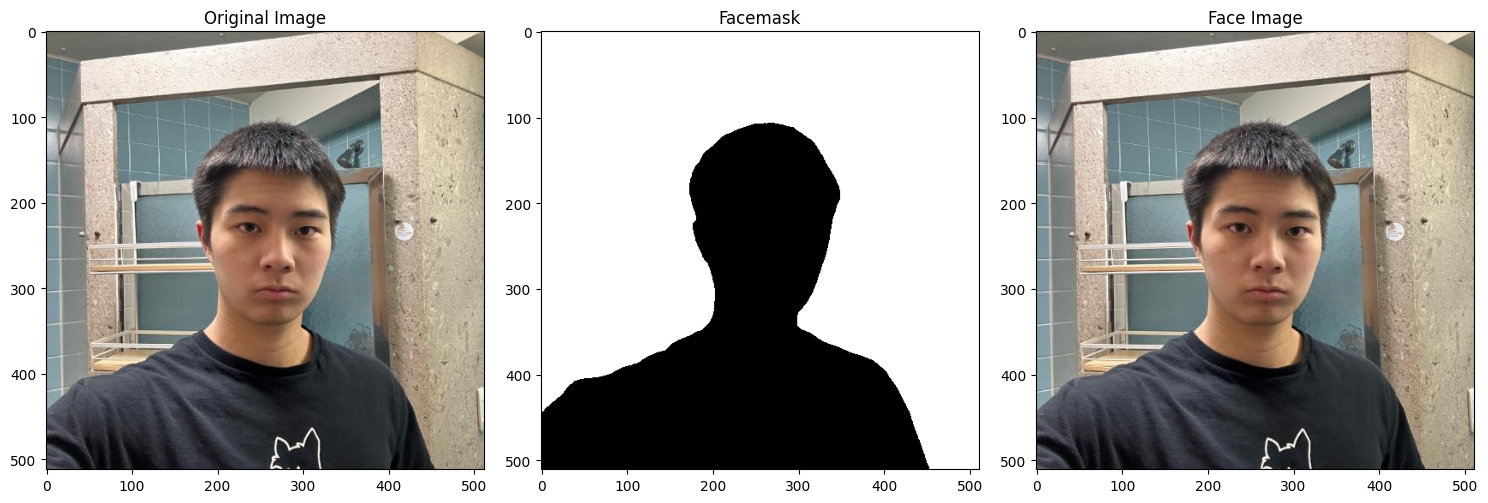

Expected input shape: torch.Size([128, 3, 3, 3])


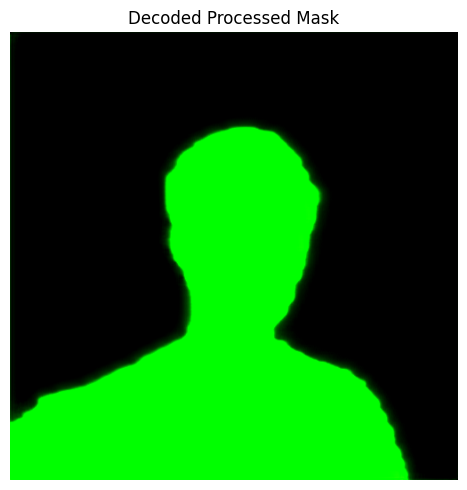

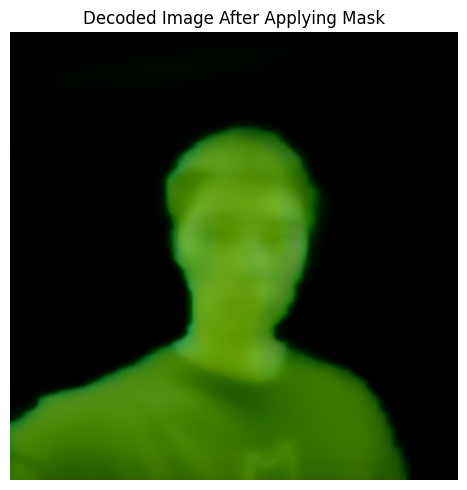

In [5]:
from PIL import Image
import numpy as np
import torch
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt


instance_image = Image.open("src/user_images/ohmw (06).jpg")
facemask, bbox = get_background_pixels_and_bbox(instance_image, mask_parts=['background', 'others'], bbox_padding=0)
face_image = instance_image.crop(bbox)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(instance_image)
ax1.set_title("Original Image")
ax2.imshow(facemask)
ax2.set_title("Facemask")
ax3.imshow(face_image)
ax3.set_title("Face Image")
plt.tight_layout()
plt.show()


vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
print("Expected input shape:", vae.encoder.conv_in.weight.shape)


mask_array = np.array(facemask.convert("RGB")).transpose(2, 0, 1)
image_array = np.array(face_image.convert("RGB")).transpose(2, 0, 1)
processed_mask_tensor = torch.from_numpy(mask_array).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)
processed_image_tensor = torch.from_numpy(image_array).unsqueeze(0).to(device=vae.device, dtype=vae.dtype)


encoded_mask = vae.encode(processed_mask_tensor).latent_dist.sample()
0
# encoded_mask = 8 - encoded_mask
# print("Inverted: ", encoded_mask)


# NORM
min_val = encoded_mask.min()
max_val = encoded_mask.max()
temp_encoded_mask = (encoded_mask - min_val) / (max_val - min_val)
# print("Normalized: ", encoded_mask)

threshold = 0.5
# multiplying by  number makes it more green too, but also gets rid of non-pure-black BG
encoded_mask = (temp_encoded_mask <= threshold).float() * 10
#print("Thresholded: ", encoded_mask)


decoded_mask = vae.decode(encoded_mask).sample
decoded_mask_image = decoded_mask.detach().cpu().squeeze().permute(1, 2, 0).numpy()
decoded_mask_image = np.clip(decoded_mask_image, 0, 1)


fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_mask_image)
ax.set_title("Decoded Processed Mask")
ax.axis("off")
plt.tight_layout()
plt.show()

# Encode and process the image
encoded_image = vae.encode(processed_image_tensor).latent_dist.sample()

multiplied_latents = (encoded_mask * encoded_image)


min_val_img = encoded_image.min()
max_val_img = encoded_image.max()
normalized_encoded_image = (encoded_image - min_val_img) / (max_val_img - min_val_img)
#print(normalized_encoded_image)


multiplied_latents = (encoded_mask * normalized_encoded_image)
# print(multiplied_latents)

# this makes the mask more "clear"
# if you remove it or just multiply by itself once, it gets more blurry
multiplied_latents = multiplied_latents # * multiplied_latents # * multiplied_latents

# # Don't threshold
# threshold_value = 0.7
# multiplied_latents = (multiplied_latents > threshold_value).float() * multiplied_latents
# multiplied_latents[multiplied_latents <= threshold_value] = 0.0
# print(multiplied_latents)


decoded_result = vae.decode(multiplied_latents).sample
decoded_image = decoded_result.detach().cpu().squeeze().permute(1, 2, 0).numpy()
decoded_image = np.clip(decoded_image, 0, 1)


fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(decoded_image)
ax.set_title("Decoded Image After Applying Mask")
ax.axis("off")
plt.tight_layout()
plt.show()